<a href="https://colab.research.google.com/github/wannasmile/colab_code_note/blob/main/AIQUANT002.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gym
import numpy as np
import pandas as pd
np.random.seed(100)

import warnings
warnings.simplefilter('ignore')

env = gym.make('CartPole-v0')

# env.seed()



In [2]:
action_size = env.action_space.n
action_size

2

In [3]:
[env.action_space.sample() for _ in range(10)]


[0, 0, 0, 1, 1, 0, 0, 1, 1, 1]

In [4]:
state_size = env.observation_space.shape[0]
state_size

4

In [5]:
state = env.reset()
state  # [cart position, cart velocity, pole angle, pole angular velocity]

array([0.02168087, 0.03888869, 0.00676449, 0.00242602], dtype=float32)

In [6]:
state, reward, done, info = env.step(env.action_space.sample())
state, reward, done, info

(array([ 0.02245865,  0.23391297,  0.00681301, -0.28811496], dtype=float32),
 1.0,
 False,
 {})

In [7]:
%%time
data = pd.DataFrame()
state = env.reset()
length = []
for run in range(25000):
    done = False
    #prev_state = env.reset()[0]
    prev_state = env.reset()
    treward = 1
    results = []
    while not done:
        action = env.action_space.sample()
        #state, reward, done, trunc, _ = env.step(action)
        state, reward, done, info = env.step(env.action_space.sample())
        results.append({'s1': prev_state[0], 's2': prev_state[1],
                        's3': prev_state[2], 's4': prev_state[3],
                        'a': action, 'r': reward})
        treward += reward if not done else 0
        prev_state = state
    if treward >= 110:
        data = pd.concat((data, pd.DataFrame(results)))
        length.append(treward)

CPU times: user 20.3 s, sys: 140 ms, total: 20.5 s
Wall time: 28.5 s


In [8]:
np.array(length).mean()

118.85714285714286

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 832 entries, 0 to 132
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   s1      832 non-null    float32
 1   s2      832 non-null    float32
 2   s3      832 non-null    float32
 3   s4      832 non-null    float32
 4   a       832 non-null    int64  
 5   r       832 non-null    float64
dtypes: float32(4), float64(1), int64(1)
memory usage: 32.5 KB


In [10]:
data.tail()

,s1,s2,s3,s4,a,r
128,1.554865,0.285955,0.080550,1.482326,1,1.0
129,1.560584,0.089948,0.110196,1.799039,1,1.0
130,1.562383,0.283678,0.146177,1.542538,1,1.0
131,1.568057,0.476772,0.177028,1.298810,0,1.0
132,1.577592,0.279900,0.203004,1.641276,0,1.0


In [11]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [12]:
from pylab import plt
plt.style.use('seaborn-v0_8')
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
tf.random.set_seed(100)

In [13]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

from keras.layers import Dense
from keras.models import Sequential

model = Sequential()
model.add(Dense(64, activation='relu',
                input_dim=env.observation_space.shape[0]))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [14]:
%%time
model.fit(data[['s1', 's2', 's3', 's4']], data['a'],
          epochs=25, verbose=False, validation_split=0.2)

CPU times: user 1.38 s, sys: 40 ms, total: 1.42 s
Wall time: 1.5 s


In [15]:
res = pd.DataFrame(model.history.history)
res.tail(3)

,loss,acc,val_loss,val_acc
22,0.685357,0.523308,0.736050,0.395210
23,0.685565,0.524812,0.734215,0.395210
24,0.684729,0.527820,0.737784,0.389222


<Axes: >

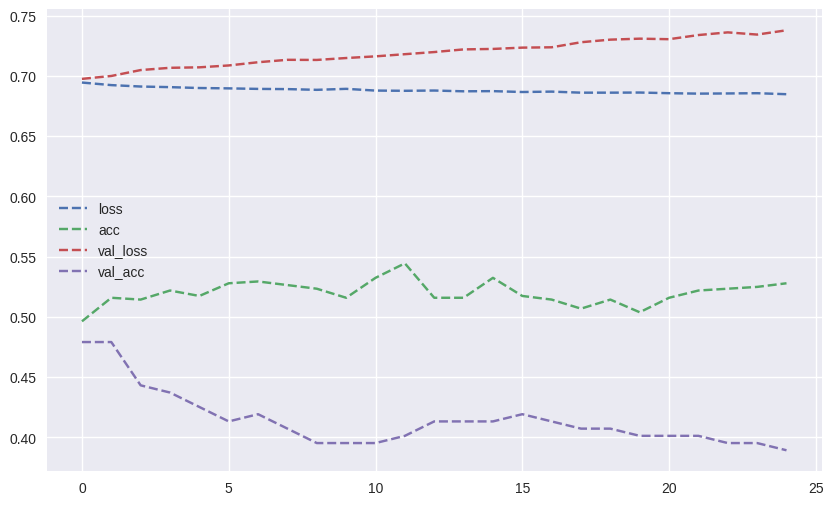

In [16]:
res.plot(figsize=(10, 6), style='--')

In [17]:
def epoch():
    print('|', end='')
    done = False
    state = env.reset()  # 从环境中获取初始状态
    treward = 0
    while not done:  # 当环境未处于完成状态时持续循环
        predicted_probabilities = model.predict(np.atleast_2d(state))  # 获取动作概率
        action = 1 if predicted_probabilities[0] > 0.5 else 0  # 根据概率决定动作
        state, reward, done, info = env.step(action)  # 执行动作并获取新的状态和奖励
        treward += reward if not done else 0  # 累积奖励
    return treward  # 返回总奖励

In [18]:
epoch()

|

46.0

In [19]:
%%time
res = np.array([epoch() for _ in range(100)])
print()
res

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
CPU times: user 5.25 s, sys: 174 ms, total: 5.42 s
Wall time: 5.39 s


array([38., 31., 40., 44., 28., 28., 24., 29., 44., 48., 41., 32., 46.,
       44., 35., 51., 31., 88., 29., 31., 38., 36., 24., 37., 39., 39.,
       41., 32., 41., 40., 31., 26., 35., 28., 38., 30., 46., 28., 32.,
       25., 47., 30., 26., 41., 45., 44., 48., 31., 68., 35., 31., 34.,
       33., 35., 37., 36., 26., 45., 34., 54., 32., 50., 25., 46., 34.,
       34., 70., 49., 27., 38., 45., 28., 38., 49., 38., 29., 32., 30.,
       39., 45., 29., 42., 46., 32., 29., 36., 40., 29., 25., 39., 42.,
       48., 29., 46., 33., 37., 36., 24., 36., 34.])

In [20]:
res.mean()

37.38

这段代码做了多个事情，分为几个部分：

> 环境和库的准备

1. 导入必要的库，设置随机种子，以确保可重现性，并忽略警告信息。

2. 创建OpenAI Gym的CartPole-v0环境。

3. 获取行动空间的大小（action_size），这是可以采取的不同行动的数量。

4. 进行10次随机行动的采样，以示例化行动空间。

5. 获取观测空间（环境状态）的大小（state_size）。

6. 重置环境，获取初始状态，并执行一个随机行动。

> 数据收集

7. 运行一个循环，进行25,000次尝试（runs）来收集环境的数据。

8. 在每次尝试中，从初始状态开始，执行随机行动，直到done标志表明回合结束。

9. 收集每一步的状态和结果，并在DataFrame data中存储它们。

10. 如果在一个尝试中的总奖励超过110，将该尝试的结果添加到data DataFrame中，并记录该尝试的总奖励。

11. 计算并打印出收集到的奖励的平均值。

> 模型的创建和训练

12. 设置TensorFlow日志级别以减少控制台输出。

13. 创建一个简单的顺序神经网络模型，用于分类任务。

14. 添加两个Dense层，第一层用ReLU激活函数，第二层用Sigmoid激活函数以输出概率。

15. 编译模型，使用二元交叉熵作为损失函数。

16. 使用之前收集的数据训练模型。

17. 绘制训练过程中的损失和准确率。

> 使用模型做出决策

18. 定义epoch函数，该函数使用训练好的模型在一个CartPole回合中做出决策，并返回该回合的总奖励。

19. 调用epoch函数一次，以测试其行为。

> 性能评估

20. 使用epoch函数运行100次回合，收集每次的总奖励。

21. 打印出这100次回合的总奖励数组。

22. 计算并打印出100次回合的平均奖励。

总结来说，该代码演示了如何使用OpenAI Gym环境进行数据收集，用这些数据训练一个简单的二分类神经网络模型，并使用这个模型来引导CartPole环境的行动，最后评估模型在多次回合中的平均性能。



```
import gym
import numpy as np
import pandas as pd
np.random.seed(100)

import warnings
warnings.simplefilter('ignore')

env = gym.make('CartPole-v0')

# env.seed()

action_size = env.action_space.n

[env.action_space.sample() for _ in range(10)]

state_size = env.observation_space.shape[0]

state = env.reset()

state, reward, done, info = env.step(env.action_space.sample())

%%time
data = pd.DataFrame()
state = env.reset()
length = []
for run in range(25000):
    done = False
    prev_state = env.reset()
    treward = 1
    results = []
    while not done:
        action = env.action_space.sample()
        #state, reward, done, trunc, _ = env.step(action)
        state, reward, done, info = env.step(env.action_space.sample())
        results.append({'s1': prev_state[0], 's2': prev_state[1],
                        's3': prev_state[2], 's4': prev_state[3],
                        'a': action, 'r': reward})
        treward += reward if not done else 0
        prev_state = state
    if treward >= 110:
        data = pd.concat((data, pd.DataFrame(results)))
        length.append(treward)

np.array(length).mean()
data.info()
data.tail()



import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from pylab import plt
plt.style.use('seaborn-v0_8')
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
tf.random.set_seed(100)

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

from keras.layers import Dense
from keras.models import Sequential

model = Sequential()
model.add(Dense(64, activation='relu',
                input_dim=env.observation_space.shape[0]))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])


%%time
model.fit(data[['s1', 's2', 's3', 's4']], data['a'],
          epochs=25, verbose=False, validation_split=0.2)

res = pd.DataFrame(model.history.history)
res.tail(3)


res.plot(figsize=(10, 6), style='--')



def epoch():
    print('|', end='')
    done = False
    state = env.reset()  # 从环境中获取初始状态
    treward = 0
    while not done:  # 当环境未处于完成状态时持续循环
        predicted_probabilities = model.predict(np.atleast_2d(state))  # 获取动作概率
        action = 1 if predicted_probabilities[0] > 0.5 else 0  # 根据概率决定动作
        state, reward, done, info = env.step(action)  # 执行动作并获取新的状态和奖励
        treward += reward if not done else 0  # 累积奖励
    return treward  # 返回总奖励



epoch()


%%time
res = np.array([epoch() for _ in range(100)])
print()
res


res.mean()
```

